In [3]:
import os
import csv

# 폴더 경로 설정
accident_folders = [
    (r"D:\classfication_data\Car-to-Car", 1),
    (r"D:\classfication_data\Car-to-motorcycle", 2),
    (r"D:\classfication_data\Car-to-bicycle", 2),
    (r"D:\classfication_data\Car-to-Human", 3),
    (r"D:\classfication_data\No Accident", 0)
]

# CSV 파일 생성
csv_file = 'image_labels.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'label'])
   
    for folder, label in accident_folders:
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            writer.writerow([img_path, label])


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


# Dataset class definition
class AccidentDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Preprocessing and data augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CSV file path
csv_file = r"C:\Users\common47\Graduation\image_labels.csv"

# Load dataset
dataset = AccidentDataset(csv_file, transform=transform)

# Split dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)



Using device: cuda


Epoch 1/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [23:24<00:00,  3.75s/it]


Epoch [1/5], Loss: 0.9114, Train Accuracy: 0.6678


Epoch 1/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [05:58<00:00,  3.82s/it]


Epoch [1/5], Val Loss: 0.7659, Val Accuracy: 0.7293


Epoch 2/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [23:45<00:00,  3.81s/it]


Epoch [2/5], Loss: 0.7104, Train Accuracy: 0.7533


Epoch 2/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:03<00:00,  3.86s/it]


Epoch [2/5], Val Loss: 0.7068, Val Accuracy: 0.7561


Epoch 3/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [25:23<00:00,  4.07s/it]


Epoch [3/5], Loss: 0.6737, Train Accuracy: 0.7661


Epoch 3/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:52<00:00,  4.39s/it]


Epoch [3/5], Val Loss: 0.6562, Val Accuracy: 0.7471


Epoch 4/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [26:41<00:00,  4.28s/it]


Epoch [4/5], Loss: 0.6314, Train Accuracy: 0.7740


Epoch 4/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:11<00:00,  3.95s/it]


Epoch [4/5], Val Loss: 0.6631, Val Accuracy: 0.7521


Epoch 5/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [25:43<00:00,  4.13s/it]


Epoch [5/5], Loss: 0.6046, Train Accuracy: 0.7892


Epoch 5/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:18<00:00,  4.03s/it]


Epoch [5/5], Val Loss: 0.6240, Val Accuracy: 0.7732


Final Validation: 100%|████████████████████████████████████████████████████████████████| 94/94 [06:38<00:00,  4.24s/it]


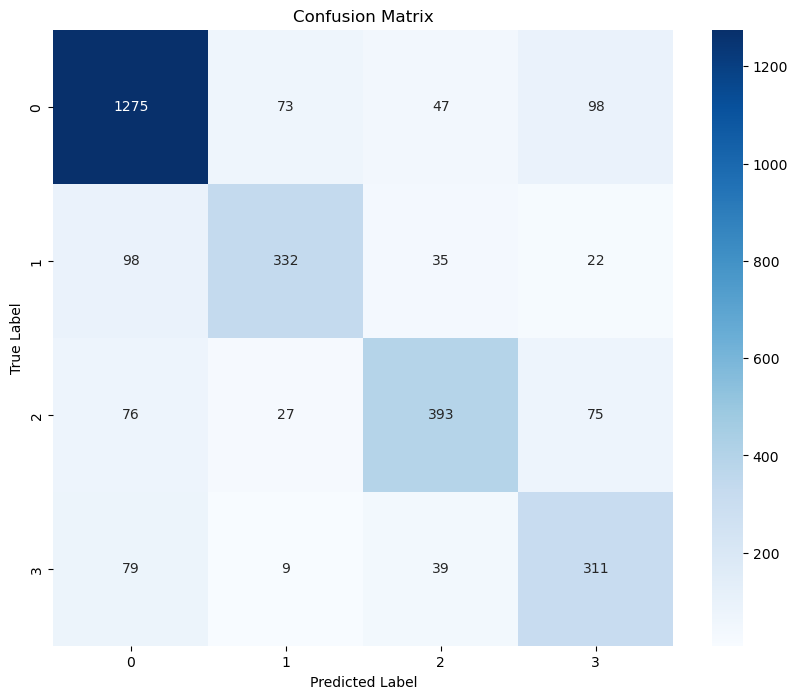

Accuracy: 0.7732
Precision: 0.7756
Recall: 0.7732
F1 Score: 0.7731


In [11]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# EfficientNet+LSTM 모델 정의
class EfficientNetLSTMClassifier(nn.Module):
    def __init__(self, num_classes, hidden_dim=128, lstm_layers=2, lstm_dropout=0.5):
        super(EfficientNetLSTMClassifier, self).__init__()
        self.cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_ftrs = self.cnn.classifier[1].in_features
        self.cnn.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, hidden_dim)
        )
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, lstm_layers, batch_first=True, dropout=lstm_dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if len(x.shape) == 5:
            batch_size, seq_length, c, h, w = x.size()
            cnn_out = []
            for t in range(seq_length):
                cnn_out.append(self.cnn(x[:, t, :, :, :]))

            cnn_out = torch.stack(cnn_out, dim=1)
            lstm_out, _ = self.lstm(cnn_out)
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        elif len(x.shape) == 4:
            cnn_out = self.cnn(x)
            lstm_out, _ = self.lstm(cnn_out.unsqueeze(1))
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        else:
            raise ValueError("Unsupported input shape")

        return out

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 초기화 및 CPU로 이동
num_classes = 4  # 데이터셋에 맞게 조정
cnn_lstm_model = EfficientNetLSTMClassifier(num_classes=num_classes)
cnn_lstm_model = cnn_lstm_model.to(device)  # GPU에서 사용할 경우 주석 처리

# 손실 함수 및 최적화 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 5
for epoch in range(num_epochs):
    cnn_lstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)  # GPU에서 사용할 경우 주석 처리
        optimizer.zero_grad()
        outputs = cnn_lstm_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # 검증
    cnn_lstm_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)  # GPU에서 사용할 경우 주석 처리
            outputs = cnn_lstm_model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_running_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

# 최종 검증 및 성능 지표 계산
cnn_lstm_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation"):
        images, labels = images.to(device), labels.to(device)  # GPU에서 사용할 경우 주석 처리
        outputs = cnn_lstm_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
